In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import  decode, decode_var, generate_bulk, get_openfraction,  get_skysign, get_skycoords, get_detimage_edges, get_detimage
from mask_utils.fits_utils import read_mask_bulk, write_mask_fits, read_fits_events
from mask_utils.image_utils import upscale#, fshift, ferosion
from scipy.signal import convolve
from scipy.ndimage import center_of_mass
from scipy.ndimage import shift as ndshift
from scipy.ndimage import gaussian_filter as gaussian_filter


import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250725.fits"

In [3]:
mask, hdmask = read_mask_bulk(mask_file, 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 3, verbose=False)
bulk = read_mask_bulk(mask_file, 4, verbose=False)

In [4]:
#Removing fractional bulk elements to simplify the analysis
bulk[bulk < 1] = 0

In [5]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] 
ELYDIM = hdmask['ELYDIM'] 
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN']
MTHICK = 0.150
focal  = 202.9 + MTHICK


In [6]:
#Upscaling mask, rmatrix, bulk
up_f_x, up_f_y = 5.0, 1.0

mask = upscale(mask, up_f_y, up_f_x)
rmatrix = upscale(rmatrix, up_f_y, up_f_x)
bulk = upscale(bulk, up_f_y, up_f_x)

ELXDIM /= up_f_x
ELYDIM /= up_f_y
ELXN   *= up_f_x
ELYN   *= up_f_y

In [7]:
def fshift(arr, lagx, lagy):
    """
    Shifts a 2D array (casted to float) with fractional shifts using SciPy.
    
    Note: SciPy's shift convention is (y, x), but our images are already in the right shape
    """
    return ndshift(arr, (lagx, lagy), 'float', order=1, prefilter=True, mode='grid-constant', cval=0.0)

<img src="autocad_test_20251023.png"> </img>

In [8]:
def ferosion( arr,step,cut, shift):
    """
    2D matrix erosion for simulating finite thickness effect in shadow projections.
    It takes a mask array and "thins" the mask elements across the columns' direction.
    """
    # number of bins to cut
    ncuts = int(cut / step) 
    print('ncuts', ncuts)
    print('cut', cut)
    
    arr_mask = (arr > 0) & (fshift(arr, round(cut / step) - np.sign(cut) , 0 ) > 0)
    cutted = arr * arr_mask if ncuts else arr

    # array indexes to be fractionally reduced:
    #   - the bin with the decimal values is the one
    #     to the left or right wrt the cutted bins
    #erosion_value =  abs(cut / step - ncuts)
    print(abs(cut / step - ncuts))
    print(shift, shift % 1)
    erosion_value = (abs(cut / step - ncuts) - (abs(shift) % 1)) % 1
    #erosion_value =1 - ( (abs(cut / step - ncuts) - (abs(shift) % 1)) % 1)

    print('erosion value', erosion_value)
    
    cutted_mask = (
        np.array((cutted > 0), dtype=int) - np.array((fshift(cutted, int(np.sign(cut)), 0) > 0), dtype=int)
    )
    border = (cutted_mask > 0)
    return cutted * (1.0 - border * erosion_value)

In [9]:
def apply_vignetting(detimage, xshift, yshift, focal, ELXDIM, ELYDIM, MTHICK):
    angle_x_rad = -np.arctan(xshift*ELXDIM / focal) #note the -1
    angle_y_rad = -np.arctan(yshift*ELYDIM / focal) #note the -1

    red_factor_x = MTHICK * np.tan(angle_x_rad) 
    red_factor_y = MTHICK * np.tan(angle_y_rad) 
    print('red_factor_x', red_factor_x)
    print('red_factor_y', red_factor_y)

    sg1 = ferosion(detimage,  ELXDIM, red_factor_x, xshift)
    sg2 = ferosion(detimage.T, ELYDIM, red_factor_y, yshift)
    sg2 = ferosion(sg1.T, ELYDIM, red_factor_y, yshift)
    #return sg1 * sg2.T 
    return sg2.T

In [10]:
def wfm_psfy(y):
    center = 0
    alpha =  0.3214
    beta = 0.624
    center, alpha, beta, skew = 0.00310926,  0.39833207,  0.62710669, -0.10536362 #cam1b
    center, alpha, beta, skew = 0.00302781,  0.40472734,  0.63778986, -0.10566557 #cam1a
    #psf = 1 / np.cosh(np.abs((y - center) / alpha) ** beta) 
    psf = 1 / (np.cosh(np.abs(( y - center) / alpha) ** beta) + (y-center) * skew)

    return psf/np.sum(psf)

In [11]:
#cam1a newpath
filein = r"F:\CodedMasks\Simulations\scox1_nocxb_2-50keV_mask_050_1040x17_10ks_infdet_opaquemask_newpathinmask\cam1a\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1a_detected.fits"

#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1a\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1a_detected.fits"
#filein = r"F:\CodedMasks\Simulations\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_newpathinmask\cam1b\scox1_2-50keV_mask_050_1040x17_1ks_infdet_opaquemask_cam1b_detected.fits"

In [12]:
from mask_utils.other_utils import filter_source
from mask_utils.other_utils import filter_energy

det, hdet0, hdet1 = read_fits_events(filein, header0=True, header1=True, verbose=False)

ra, dec = 244.979705810547, -15.6400995254517 #Sco X-1
#ra, dec = 270.284790039063, -25.0774002075195 #GX 5-1

det = filter_source(det, ra, dec, verbose=True)
#det = filter_energy(det, 2.0, 5.0, verbose=True)

xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)
#Computes detector image
detimagesim = get_detimage(det, xedges, yedges) * bulk

Selected 11038560 out of 11038560 events


In [13]:
skysim = decode(detimagesim, rmatrix, bulk)

peak = np.max(skysim)
peak_p = np.unravel_index(np.argmax(skysim), skysim.shape)
print(peak_p)

(np.int64(6077), np.int64(677))


In [14]:
#skysim = skydiff
xspan = int(0.25/ELXDIM)
yspan = int(15.5/ELYDIM)

labels = np.zeros(skysim.shape)
labels[peak_p[0] - xspan : peak_p[0] + xspan + 1 , peak_p[1] - yspan : peak_p[1] + yspan + 1] = 1

com = center_of_mass(skysim, labels=labels, index=1)
cx, cy = (skysim.shape[0] - 1 ) // 2, (skysim.shape[1] - 1 ) // 2

shiftX, shiftY = cx - com[0] - 0.324 , cy - com[1] - 0.632  #cam1a ups 5,1 detected Sco X-1 10ks
#shiftX, shiftY = cx - com[0] - 0.570 , cy - com[1] + 1.0  #cam1b ups 5,1 detected Sco X-1 10ks

print("Peak Center Of Mass:", com[0], com[1])
print("ShiftX [px]:", shiftX)
print("ShiftY [px]:", shiftY)
print("ShiftX [deg]:", -np.rad2deg(np.arctan((shiftX*ELXDIM)/(focal))))
print("ShiftY [deg]:", -np.rad2deg(np.arctan((shiftY*ELYDIM)/focal)))
print("ShiftX [mm]:", -shiftX * ELXDIM)
print("ShiftY [mm]:", -shiftY * ELYDIM)


Peak Center Of Mass: 6076.874104349888 676.4652942995509
ShiftX [px]: -878.1981043498876
ShiftY [px]: -156.09729429955092
ShiftX [deg]: 12.202410318929475
ShiftY [deg]: 21.025832352818227
ShiftX [mm]: 43.909905217494384
ShiftY [mm]: 78.04864714977546


In [15]:
ypsf = np.arange(-yspan, yspan+1) * ELYDIM
psf =  wfm_psfy(ypsf).reshape(len(ypsf), -1)

'''
detimage_iros = mask
detimage_iros = apply_vignetting(detimage_iros, shiftX, shiftY, focal, ELXDIM, ELYDIM, MTHICK)
detimage_iros = gen_detimage(detimage_iros, shiftX, shiftY, bulk)#, psf=psf.T)
'''

shifted = fshift(mask, shiftX, shiftY)
vignetted = fshift(apply_vignetting(mask, shiftX, shiftY, focal, ELXDIM, ELYDIM, MTHICK), int(shiftX), int(shiftY))
detimage_iros = vignetted * shifted * bulk

skyiros = decode(detimage_iros, rmatrix, bulk) 
skyiros = skyiros / np.max(skyiros) * np.max(skysim)

red_factor_x 0.03243775317716896
red_factor_y 0.0576572128661232
ncuts 0
cut 0.03243775317716896
0.6487550635433792
-878.1981043498876 0.8018956501124421
erosion value 0.4506507136558213
ncuts 0
cut 0.0576572128661232
0.1153144257322464
-156.09729429955092 0.9027057004490757
erosion value 0.01802012618132212
ncuts 0
cut 0.0576572128661232
0.1153144257322464
-156.09729429955092 0.9027057004490757
erosion value 0.01802012618132212


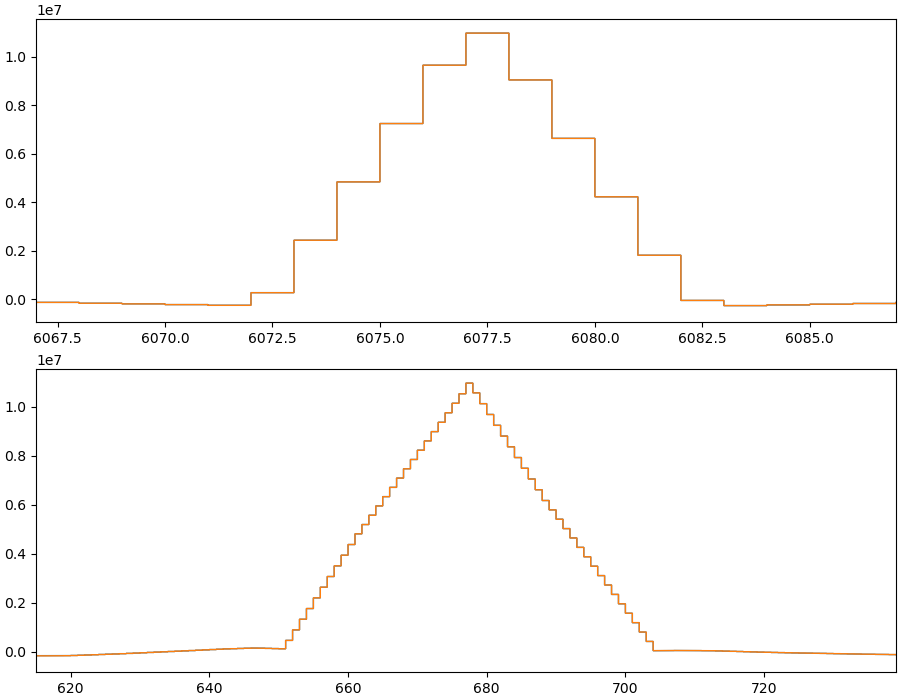

In [16]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skysim[:, peak_p[1]])
axs[0].stairs(skyiros[:, peak_p[1]])

axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))


axs[1].set_title('')
axs[1].stairs(skysim[peak_p[0], :])
axs[1].stairs(skyiros[peak_p[0], :])

axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

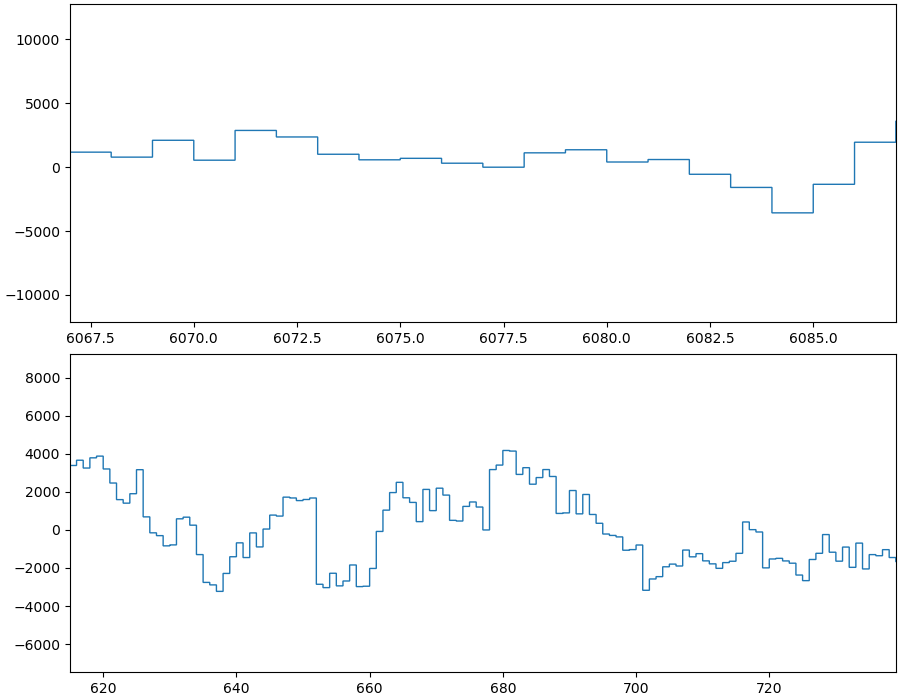

In [17]:
skydiff = skysim - skyiros

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skydiff[:, peak_p[1]])
axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))

axs[1].set_title('')
axs[1].stairs(skydiff[peak_p[0], :])
axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

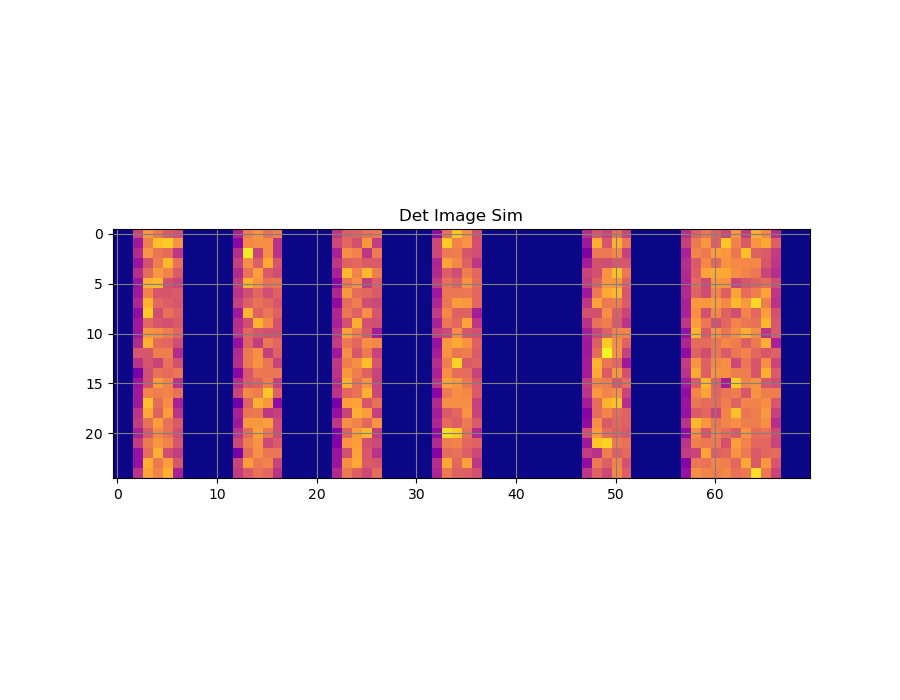

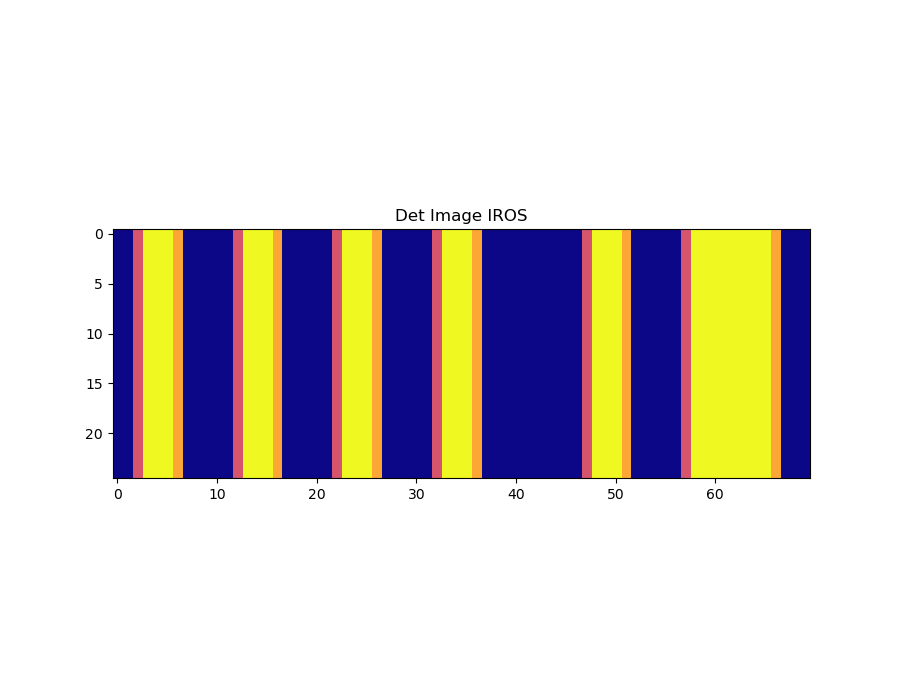

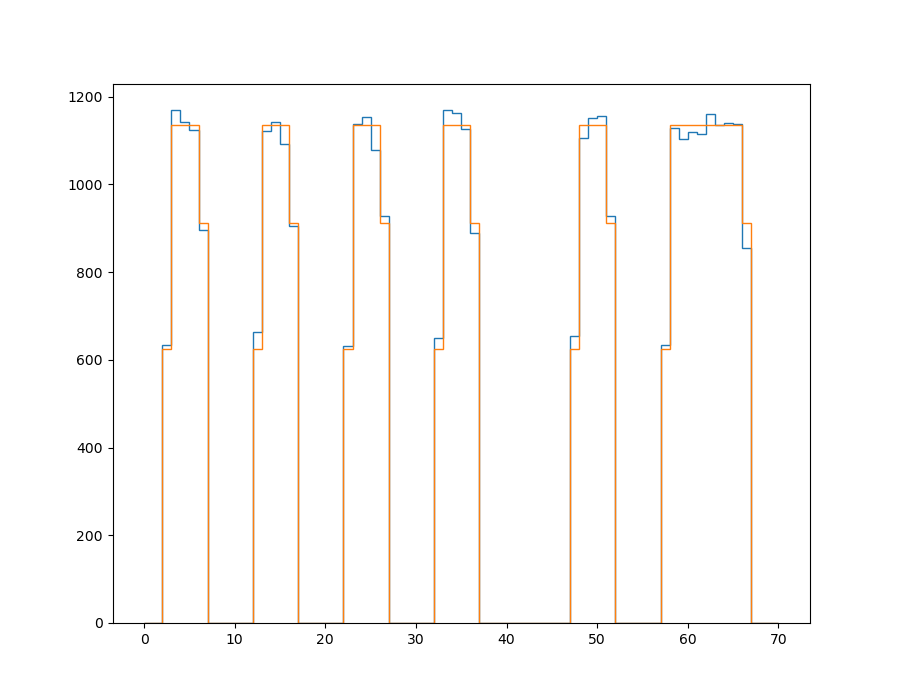

In [18]:
norm = np.sum(detimagesim)/np.sum(detimage_iros)
f = int(up_f_x/5)
appo_sim = detimagesim[1825*f:1895*f, 186:211]
appo_iros = detimage_iros[1825*f:1895*f, 186:211]

'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Sim")
plt.imshow(detimagesim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()
'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Sim")
#plt.imshow(appo_sim[164:225, 5:35].T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM) #cam1a
plt.imshow(appo_sim.T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM) #cam1a
plt.grid(which= 'both', color='gray')
#plt.imshow(appo_sim.T[5:31, 12:55], cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

plt.figure(figsize=(9, 7))
plt.title("Det Image IROS")
plt.imshow(appo_iros.T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1a
#plt.imshow(appo_iros[164:225, 5:35].T, cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1a
#plt.imshow(appo_iros.T[5:31, 12:55], cmap=cm.plasma,  interpolation='nearest')#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

'''
plt.figure(figsize=(9, 7))
plt.title("Det Image Diff")
#plt.imshow(appo_sim[164:175, 12:15].T - appo_iros[164:175, 12:15].T * norm, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)#cam1a
plt.show()
'''
plt.figure(figsize=(9, 7))
norm = appo_sim.T.sum()/appo_iros.T.sum()
plt.stairs(appo_sim.T.sum(axis=0))#, aspect=ELYDIM/ELXDIM)#cam1b
plt.stairs(appo_iros.T.sum(axis=0) * norm)#, aspect=ELYDIM/ELXDIM)#cam1b
plt.show()

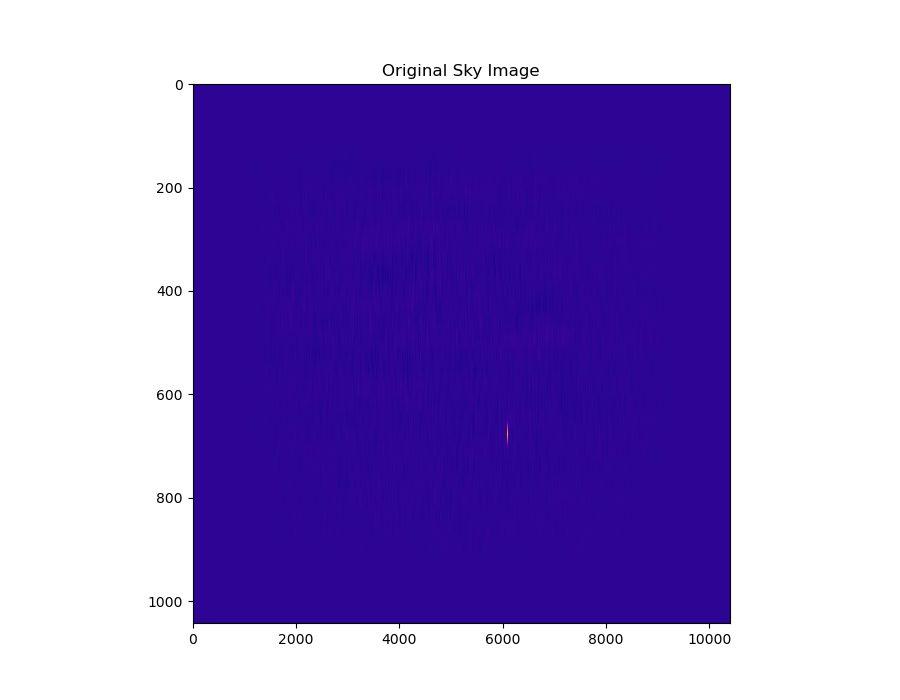

In [19]:
plt.figure(figsize=(9, 7))
plt.title("Original Sky Image")
plt.imshow(skysim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

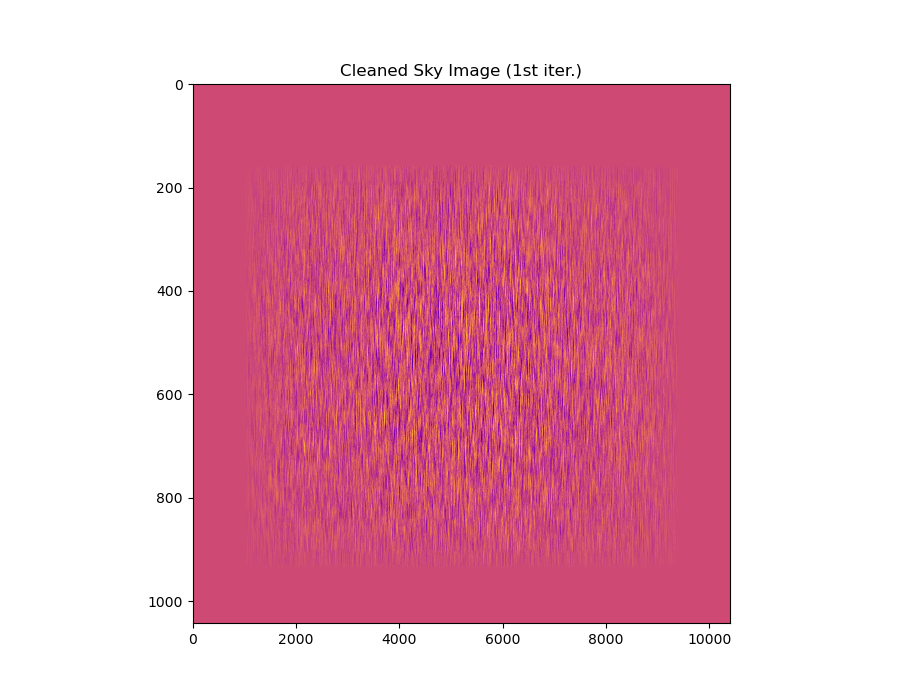

In [20]:
plt.figure(figsize=(9, 7))
plt.title("Cleaned Sky Image (1st iter.)")
plt.imshow(skydiff.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

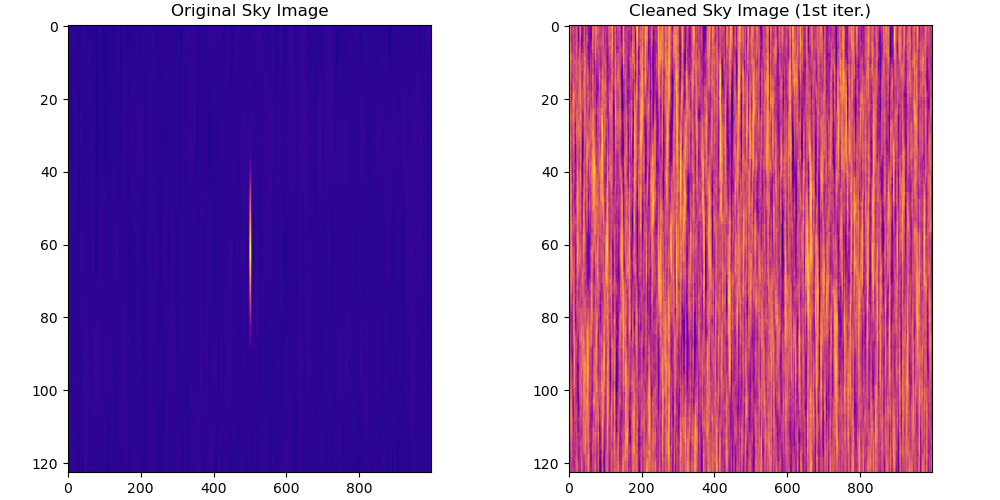

In [21]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
vmin, vmax = np.min(skysim),np.max(skysim)
axs[0].set_title('Original Sky Image')
axs[0].imshow(skysim[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma, vmin=vmin, vmax=vmax, interpolation='nearest', aspect=ELYDIM/ELXDIM)

axs[1].set_title('Cleaned Sky Image (1st iter.)')
axs[1].imshow(skydiff[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()